In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run nnn/ipynb_init.py

from PIL import Image

In [2]:
from nnn.arraydata import ArrayData
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file='./data/annotation/NNNlib2b_annotation_20220519.tsv')
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_20220519.tsv')
kB = 0.0019872

75.87% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


# Figure 1c variant schematics

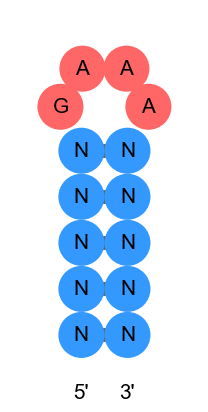

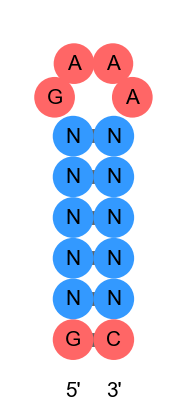

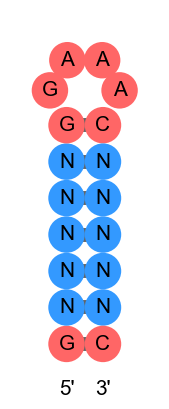

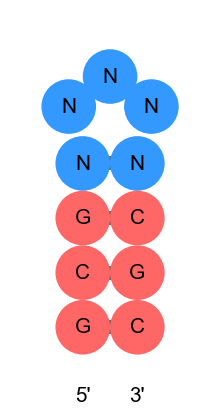

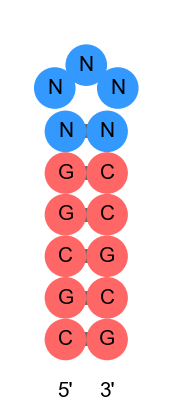

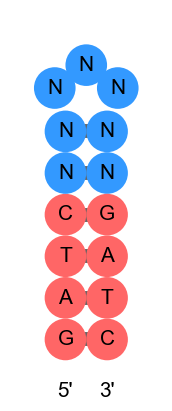

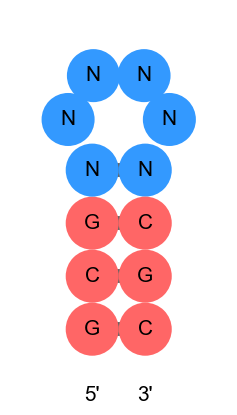

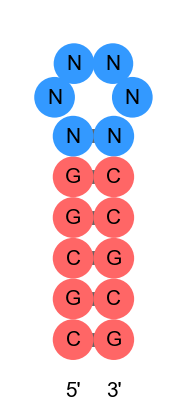

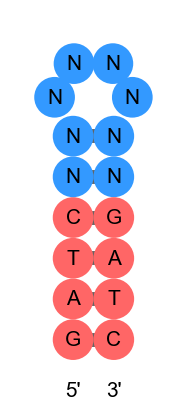

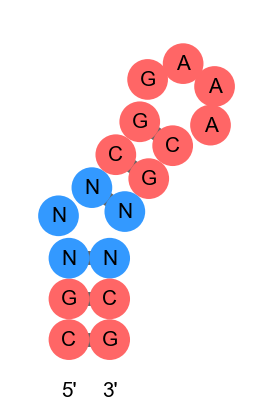

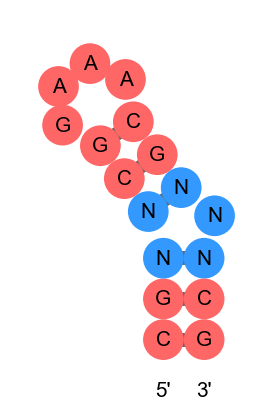

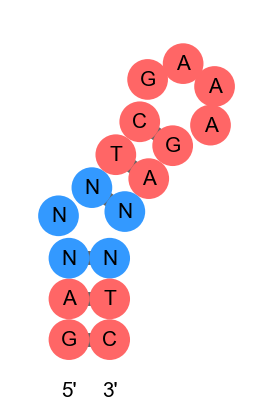

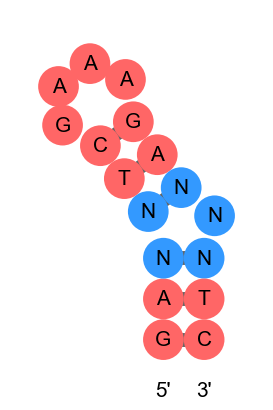

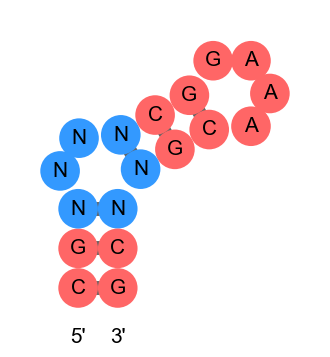

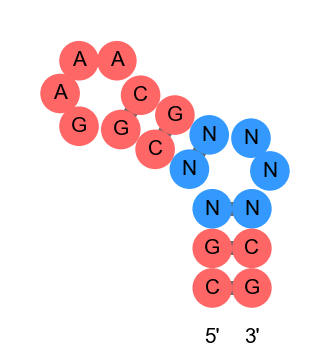

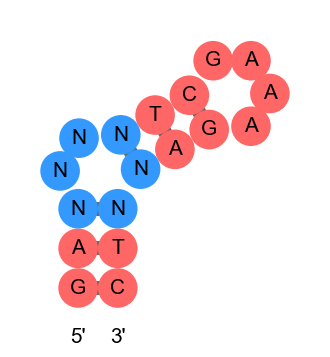

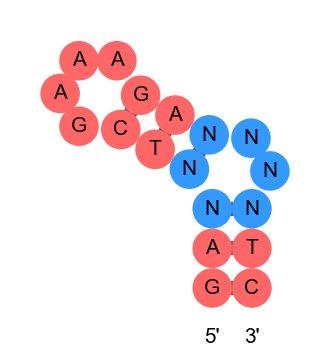

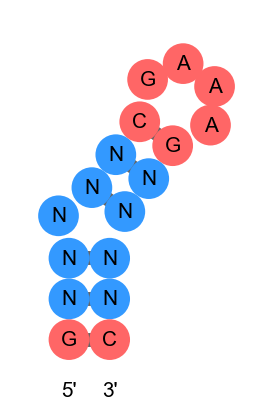

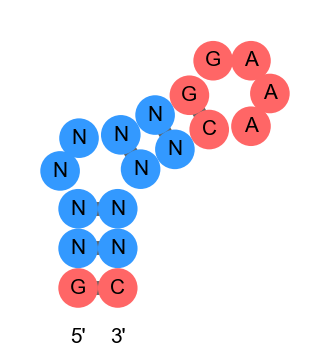

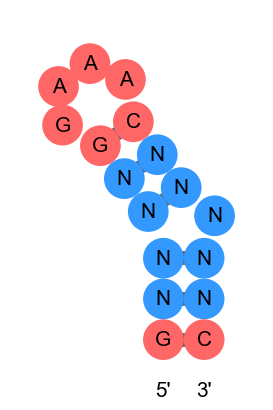

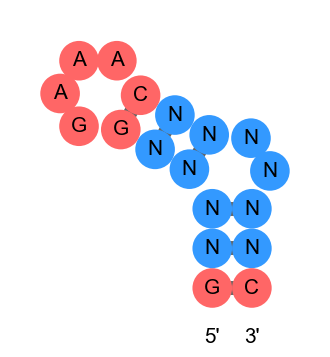

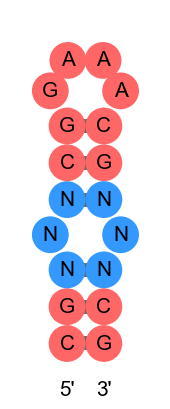

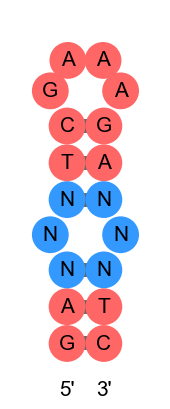

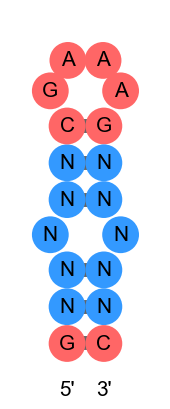

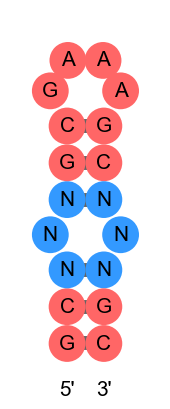

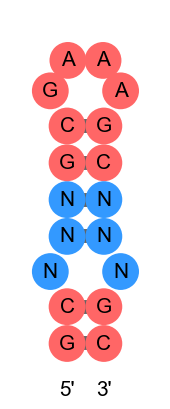

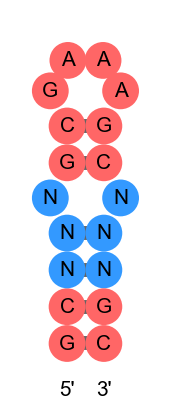

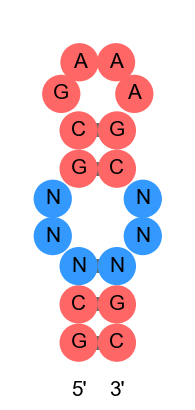

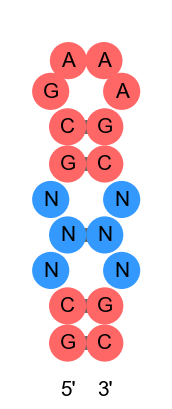

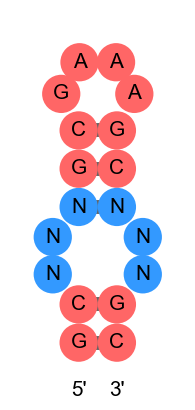

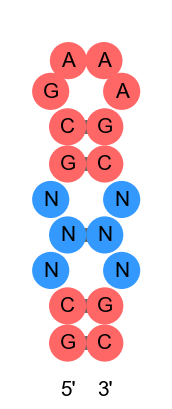

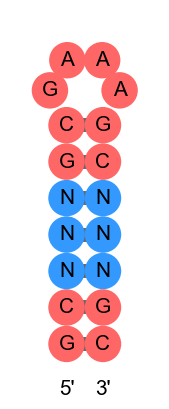

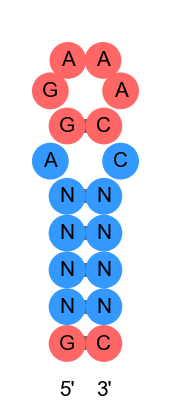

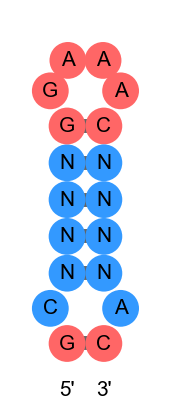

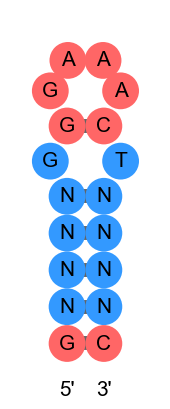

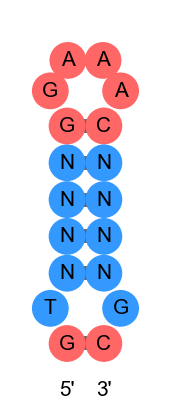

In [9]:
with open('./data/figure/allclasses.txt', 'r') as fh:
    allclasses = fh.readlines()

if len(allclasses) % 5 == 4:
    allclasses.append('\n')
classes_arr = np.array([s.strip('\n') for s in allclasses]).reshape(-1, 5)[:,:4]

df = pd.DataFrame(data=classes_arr, columns=['seqname', 'sequence', 'structure', 'color'])

figdir = './fig/allclasses/'
    
for i,row in df.iterrows():

    filename = figdir + row.seqname + '.svg'
    fig, ax = plt.subplots(figsize=(4,5))
    draw_struct(row.sequence, row.structure, row.color, ax=ax)
    util.save_fig(filename)

# Class sizes

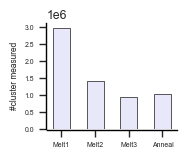

In [14]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
xlabels = ['Melt%d'%(i+1) for i in range(3)] + ['Anneal']
plt.bar(xlabels, arraydata.data_all[[c for c in arraydata.data_all.columns if c.startswith('n_clusters')]].sum(axis=0),
       fill=True, edgecolor='k', alpha=.9, color='lavender', linewidth=0.5, width=.5)
# plt.yscale('log')
sns.despine(trim=False, offset=1)
ax.set_ylabel('#cluster measured', size=label_font_size)
ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
util.save_fig('./fig/accounting/number_clusters.pdf')

# Example curves

In [5]:
r1 = arraydata.get_replicate_data('r1', attach_annotation=True)

def plot_3_example_curves(seqid_list, repdata, figname=None):
    palette=['#2f4f4f','#228b22','#00ff00','#000080','#1e90ff','#00ffff','#deb887','#ff8c00','#8b4513','#ff0000','#ff69b4','#800080',]
    
    fig, ax = plt.subplots(1,3, figsize=(3*4.25*cm, 3.5*cm), sharey=True)
    ax = ax.flatten()

    for i in range(len(seqid_list)):
        plotting.plot_actual_and_expected_fit(r1.loc[seqid_list[i],:], ax[i], c=palette[i+6])
        ax[i].set_title('GC = %.1f%%'%repdata.loc[seqid_list[i], 'GC'], fontsize=label_font_size, fontweight='bold')

        ax[i].xaxis.set_major_locator(MultipleLocator(20))
        ax[i].xaxis.set_minor_locator(MultipleLocator(5))
        ax[i].yaxis.set_major_locator(MultipleLocator(0.5))
        ax[i].yaxis.set_minor_locator(MultipleLocator(0.25))

        sns.despine(trim=False)

        ax[i].tick_params(axis='both', which='major', labelsize=tick_font_size)
        ax[i].set_xlabel('temperature (°C)', fontsize=tick_font_size)
        if i == 0:
            ax[i].set_ylabel('normalized fluorescence (a.u.)', fontsize=tick_font_size)

    util.save_fig('./fig/example_curves/curves_3.pdf')
    plt.show()

Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


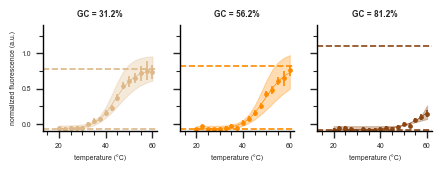

In [6]:
df = r1.query('Series == "WatsonCrick" & ConstructType == "WC_6ntstem" & RMSE < 0.08')
df['GC'] = df.RefSeq.apply(util.get_GC_content)
df.sort_values(by='GC', inplace=True)

seqid_list = [df.index[0], df.index[len(df) // 2 + 16], df.index[-1]]
plot_3_example_curves(seqid_list, r1)

In [14]:
arraydata.data.loc[seqid_list].join(arraydata.annotation).to_csv('./data/misc/Fig1_example_3_seqeunces.csv')

Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values


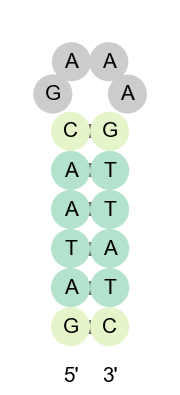

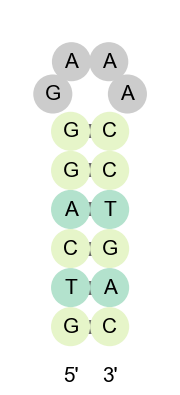

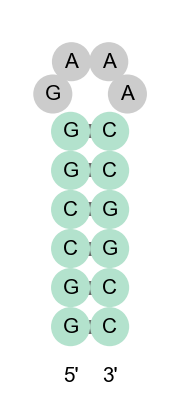

In [28]:
""" Make some cartoons for the example curves
"""
for seqid in seqid_list:
    seq = r1.loc[seqid, 'RefSeq']
    gc_coding = seq.replace('GAAA','2222').replace('G','1').replace('C','1').replace('A','0').replace('T','0')
    
    fig, ax = plt.subplots()
    draw_struct(seq, r1.loc[seqid, 'TargetStruct'], gc_coding, cmap='Pastel2', ax=ax)
    util.save_fig(f'./fig/example_curves/structs/{seqid}_structure.svg', fig=fig)

# Error binned on param

In [29]:
df = arraydata.data.join(annotation.set_index('SEQID'))

# Bin on param
df['dG_37_bin'] = pd.qcut(df.dG_37, 5, precision=0)
# df['Tm_bin'] = pd.cut(df.Tm, 5)

# Annotate Series size for later filtering
major_series = annotation.groupby('Series').apply(len)
major_series = pd.DataFrame(major_series, columns=['Series_size'])
df = df.join(major_series, on='Series')

# Rename the Series
series_rename_dict = {s: s.title() for s in np.unique(df['Series'].values.astype('str'))}
series_rename_dict["WatsonCrick"] = "Watson Crick"
df = df.replace({'Series': series_rename_dict})

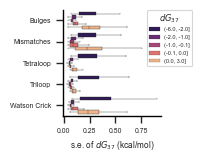

In [30]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
# fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
sns.boxplot(data=df.query("Series_size > 1000"), orient='h', x='dG_37_se', y='Series', hue='dG_37_bin', 
            showfliers = False, palette='magma', linewidth=0.25, ax=ax)

ax.get_legend().remove()
ax.set_ylabel('')
ax.set_xlabel('s.e. of $dG_{37}$ (kcal/mol)', size=label_font_size)
# ax.xaxis.set_minor_locator(MultipleLocator(0.4))
# ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
sns.despine(trim=False)

h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4}, title='$dG_{37}$', title_fontsize=label_font_size)
lax.axis("off")
util.save_fig('./fig/uncertainty_breakdown/dG_se_by_series.pdf')

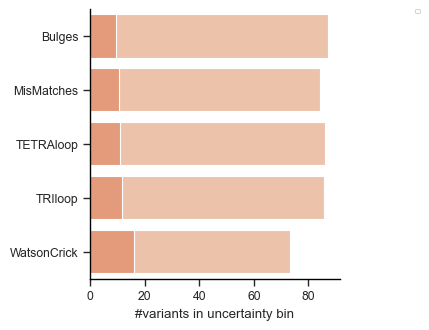

In [31]:
fig, (ax, lax) = plt.subplots(1, 2, figsize=(4.25, 3.5), gridspec_kw={"width_ratios":[5,1]})

for i,se_bin in enumerate(se_bin_df.columns[:2]):
    sns.barplot(data=se_bin_norm_df.reset_index(), orient='h', y='Series', x=se_bin, color=sns.color_palette('rocket_r', 8)[i], 
                ax=ax)

ax.set_ylabel('')
ax.set_xlabel('#variants in uncertainty bin')
sns.despine(trim=False)
plt.xscale('log')
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")
util.save_fig('./fig/uncertainty_breakdown/dG_se_by_series_stacked_bar.pdf')

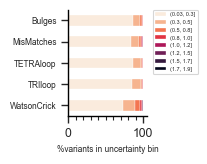

In [22]:
cross_tab_prop = pd.crosstab(index=df.query("Series_size > 1000").Series, columns=df.query("Series_size > 1000").dG_37_se_bin, normalize='index') * 100

fig, (ax, lax) = plt.subplots(1, 2, figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[2,1]})
cross_tab_prop.iloc[::-1].plot(kind='barh', 
                    stacked=True, 
                    colormap='rocket_r', 
                    linewidth=0.25,
                    ax=ax)

ax.get_legend().remove()
ax.set_ylabel('')
ax.set_xlabel('%variants in uncertainty bin', fontsize=label_font_size)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=label_font_size)

ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=label_font_size)
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

sns.despine()
util.save_fig('./fig/uncertainty_breakdown/dG_se_bin_by_series.pdf')

# Length dependency

In [32]:
datadir = './data/'
r2_series = pd.read_pickle(os.path.join(datadir, 'series_merged/NNNlib2b_DNA_20211221.pkl'))

(array([-500.,    0.,  500., 1000., 1500., 2000.]),
 [Text(0, -500.0, '−500'),
  Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000')])

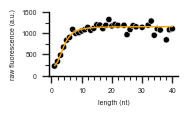

In [33]:
"""
Pooled repeatseries and polyA
- with fitted theoretical line
"""

from lmfit import minimize, Parameters

def is_polyA(refseq):
    return refseq.count('A') == len(refseq)

def is_polyT(refseq):
    return refseq.count('T') == len(refseq)

def residual(params, x, data):
    a = params['a']
    b = params['b']
    fmax = params['fmax']
    fmin = params['fmin']
    
    model = (fmax - fmin) / (1 + (a * (x + b)**(-3))) + fmin
    
    return model - data

repeat_series = r2_series.query('Series == "REPeatControls" | Series == "PolyNTControls"')
repeat_series['polyT'] = repeat_series.RefSeq.apply(is_polyT)
repeat_series = repeat_series[np.logical_not(repeat_series.polyT)]

repeat_series['length'] = repeat_series.RefSeq.apply(len)
length_dep = repeat_series[['length', 'Green20_40.0']].groupby('length').apply(np.nanmean)
length_dep = length_dep#[:20]

fmax, fmin = 1000, 0
params = Parameters()
params.add('a', value=50)
params.add('b', value=0, min=0, vary=True)
params.add('fmax', value=fmax, vary=True)
params.add('fmin', value=fmin, vary=True)

x = length_dep.index
data = length_dep.values
out = minimize(residual, params, args=(x, data))
length_theoretical = residual(out.params, x, data) + data

fig, ax = plt.subplots(figsize=(4.25*cm, 0.6*3.5*cm))
sns.scatterplot(x=length_dep.index, y=length_dep, color='k', size=length_dep.index, sizes=(20,20))
plt.plot(length_dep.index, length_theoretical, color='orange', linewidth=1)

ax.get_legend().remove()
sns.despine(trim=False)
ax.set_xlabel('length (nt)', fontsize=tick_font_size)
ax.set_ylabel('raw fluorescence (a.u.)', fontsize=tick_font_size)
ax.set_ylim(bottom=0, top=1500)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(250))

plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

# util.save_fig('./fig/length_dependency/length_dependency_repeats_and_polyA.pdf')

In [34]:
# Print the repeats
', '.join(np.unique([x[:3] for x in repeat_series.RefSeq]))

'A, AA, AAA, AAC, AAG, AAT, AC, ACA, ACC, AG, AGA, AGG, AT, ATA, TA, TAT, TC, TCT, TG, TGT, TTA, TTC, TTG, TTT'

In [35]:
# print the fitted parameters
out.params

name,value,standard error,relative error,initial value,min,max,vary
a,71.1852990,73.3538863,(103.05%),50,-inf,inf,True
b,0.07648069,1.79990513,(2353.41%),0,0.00000000,inf,True
fmax,1153.30987,28.2520628,(2.45%),1000,-inf,inf,True
fmin,214.775872,171.688464,(79.94%),0,-inf,inf,True


In [38]:
# Estimate BHQ affinity
a = out.params['a'].value
N_A = 6.023 * 1e23
k = 0.64 * 1e-9
K_D_BHQ = (2*np.pi/3)**(2/3) / (a *N_A * k**3)

R = 0.00198717 # gas constant in kcal/mol not J
dG_37_BHQ = - R * (273.15 + 37) * np.log(K_D_BHQ)
K_D_BHQ, dG_37_BHQ

(145.64513315427448, -3.070000448282724)

# Box plot

In [50]:
import kaleido

import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'jupyterlab'

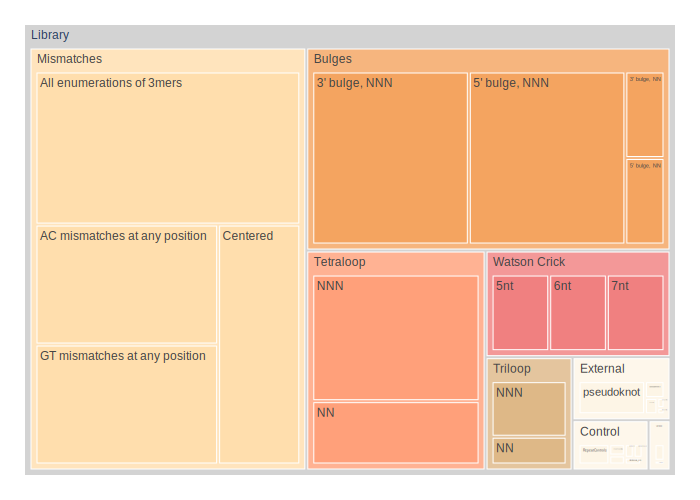

In [59]:
warm_palette = ['#2f4f4f','#228b22','#00ff00','#000080','#1e90ff','#00ffff','#ff8c00','#deb887','#8b4513','#ff0000','#ff69b4','#800080',]
mpl_palette = ["navajowhite", "sandybrown", "lightsalmon", "lightcoral", "burlywood","oldlace", "oldlace", "oldlace"]
df = annotation[['Series', 'ConstructType']]
series_rename_dict = {s: s.title() for s in np.unique(df.Series)}
series_rename_dict["WatsonCrick"] = "Watson Crick"
# series_rename_dict["External"] = "Control"
rename_dict = dict(AC_mismatch_varpos='AC mismatches at any position',
                   GT_mismatch_varpos='GT mismatches at any position',
                   NNN_3primebulge="3' bulge, NNN", NNN_5prime_bulge="5' bulge, NNN",
                   NN_3primebulge="3' bulge, NN", NN_5primebulge="5' bulge, NN",
                   WC_5ntstem='5nt', WC_6ntstem='6nt', WC_7ntstem='7nt',
                   pseudoknot_pt_muts='pseudoknot')
rename_dict['3mer'] = 'All enumerations of 3mers'

df = df.replace({"ConstructType": rename_dict, 'Series': series_rename_dict})

fig = px.treemap(df, path=[px.Constant("Library"), 'Series', 'ConstructType'])
fig.update_traces(root_color="lightgray")

fig.update_layout(
    font_family = "Arial",
    treemapcolorway = mpl_palette,#warm_palette[6:14],
    margin = dict(t=25, l=25, r=25, b=25)
)
fig.show(renderer="svg")
fig.write_image('./fig/Fig1/treemap.svg', engine='kaleido')

# Melt Anneal

In [34]:
df = arraydata.data.join(revdata.data, lsuffix='_heating', rsuffix='_cooling')

CPU times: user 6.97 s, sys: 353 ms, total: 7.32 s
Wall time: 5.5 s


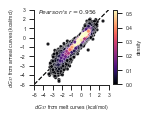

In [48]:
%%time
from scipy.stats import pearsonr

# orange_palette = sns.dark_palette(palette[6], reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
lim = [-5, 3]
l = lim[1] - lim[0]
df = df.dropna()
pearson, _ = pearsonr(df['dG_37_heating'], df['dG_37_cooling'])
plotting.plot_colored_scatter_comparison(data=df, x='dG_37_heating', y='dG_37_cooling',
                                         palette='magma', lim=lim, alpha=.9, ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlabel('$dG_{37}$ from melt curves (kcal/mol)', fontsize=tick_font_size)
ax.set_ylabel('$dG_{37}$ from anneal curves (kcal/mol)', fontsize=tick_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
sns.despine(offset=0)

plt.text(lim[0] + 0.05*l, lim[1] - 0.1*l, r"$Pearson's\ r = %.3f$"%pearson, va='bottom', fontsize=label_font_size)

util.save_fig('./fig/heat_cool/relplot_heat_cool.pdf')


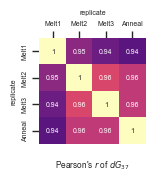

In [48]:
corr_mat = plotting.get_pairwise_pearsonr_matrix([ arraydata.data_all[['dG_37-r1']],
                                                   arraydata.data_all[['dG_37-r2']],
                                                   arraydata.data_all[['dG_37-r3']],
                                                   revdata.data[['dG_37']],
                                                   ])
ticks = ['Melt1', 'Melt2', 'Melt3', 'Anneal']
# mask = np.zeros_like(corr_mat)
# mask[np.tril_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
im = sns.heatmap(corr_mat, vmin=0.92, vmax=0.99, 
                 cmap='magma', cbar=False, linewidths=0, square=True,
                annot=True, annot_kws={'size': 5})
ax.set_xticklabels(ticks, size=tick_font_size)
ax.set_yticklabels(ticks, size=tick_font_size)
ax.set_xlabel('replicate', size=tick_font_size)
ax.set_ylabel('replicate', size=tick_font_size)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_title("Pearson's $r$ of $dG_{37}$", y=-.3, size=label_font_size)

util.save_fig('./fig/heat_cool/corr_mat.pdf')

# Raw images

!! Cannot be run locally: raw image data are on sherlock because they are too big !!

In [3]:
def get_tile_filename(imagedir, condition, tile):
    found_filename = [fn for fn in os.listdir(os.path.join(imagedir, condition)) if '_tile%d_'%tile in fn]
    assert len(found_filename) == 1, print(found_filename)
    return os.path.join(imagedir, condition, found_filename[0])

def get_cropped_tif(filename, crop_tuple=(1024,1024,256,256)):
    x0, y0, dx, dy = crop_tuple
    im = np.array(Image.open(filename))[x0:x0+dx, y0:y0+dy]
    return im

def normalize_image(img, norm_max_min, celsius):
    fmax, fmin = norm_max_min.loc[celsius, :]
    return (img - fmin) / (fmax - fmin)

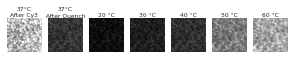

In [5]:
"""
one row
"""
label_font_size = 6
title_args = dict(fontsize=label_font_size, pad=0)
experiment = '20220314'
datadir = '/scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/'
imagedir = os.path.join(datadir, 'images_' + experiment)
condition = ['Green07_Cy3', 'Green09_Quench', 'Green10_20', 'Green14_30', 'Green18_40','Green22_50', 'Green26_60']
T = [37.5, 37.5, 20, 30, 40, 50, 60]
tile = 9

norm_max_min = pd.read_table(os.path.join(datadir, 'series_normalized', 'NNNlib2b_DNA_%s_norm_max_min.tsv'%experiment))
xdata = pd.read_table(os.path.join(datadir, 'series_normalized', 'NNNlib2b_DNA_%s_xdata.txt'%experiment), header=None) - 273.15
norm_max_min.index = np.array(xdata).squeeze()

filenames = [get_tile_filename(imagedir, c, tile) for c in condition]

fig, ax = plt.subplots(1,7,figsize=(3*4.25*cm, 3.5*cm))
for i in range(2):
    im = im = get_cropped_tif(filenames[i], (512, 1024, 128,128))
    norm_im = normalize_image(im, norm_max_min, T[i])
    ax[i].imshow(norm_im, cmap='gray', vmin=300, vmax=2200)
    ax[i].axis('off')
    
ax[0].set_title('37°C\nAfter Cy3', fontsize=label_font_size, pad=0)
ax[1].set_title('37°C\nAfter Quench', fontsize=label_font_size, pad=0)

    
for i in range(5):
    im = im = get_cropped_tif(filenames[i+2], (512, 1024, 128,128))
    norm_im = normalize_image(im, norm_max_min, T[i+2])
    ax[i+2].imshow(norm_im, cmap='gray', vmin=300, vmax=2200)
    ax[i+2].axis('off')
    ax[i+2].set_title('%d °C'%T[i+2], fontsize=label_font_size, pad=0)
    
util.save_fig('./fig/raw_image/all_examples_one_row.pdf')

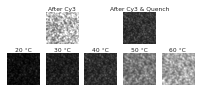

In [44]:
"""
two rows
"""
label_font_size = 6
title_args = dict(fontsize=label_font_size, pad=0)
experiment = '20220314'
datadir = '/scratch/groups/wjg/kyx/NNNlib2b_Nov11/data/'
imagedir = os.path.join(datadir, 'images_' + experiment)
condition = ['Green07_Cy3', 'Green09_Quench', 'Green10_20', 'Green14_30', 'Green18_40','Green22_50', 'Green26_60']
T = [37.5, 37.5, 20, 30, 40, 50, 60]
tile = 9

norm_max_min = pd.read_table(os.path.join(datadir, 'series_normalized', 'NNNlib2b_DNA_%s_norm_max_min.tsv'%experiment))
xdata = pd.read_table(os.path.join(datadir, 'series_normalized', 'NNNlib2b_DNA_%s_xdata.txt'%experiment), header=None) - 273.15
norm_max_min.index = np.array(xdata).squeeze()

filenames = [get_tile_filename(imagedir, c, tile) for c in condition]

fig, ax = plt.subplots(2,5,figsize=(2*4.25*cm, 3.5*cm))
for i in range(2):
    im = im = get_cropped_tif(filenames[i], (512, 1024, 128,128))
    norm_im = normalize_image(im, norm_max_min, T[i])
    ax[0][2*i + 1].imshow(norm_im, cmap='gray', vmin=300, vmax=2200)
    
ax[0][1].set_title('After Cy3', fontsize=label_font_size, pad=0)
ax[0][3].set_title('After Cy3 & Quench', fontsize=label_font_size, pad=0)
    
for i in range(5):
    im = im = get_cropped_tif(filenames[i+2], (512, 1024, 128,128))
    norm_im = normalize_image(im, norm_max_min, T[i+2])
    ax[1][i].imshow(norm_im, cmap='gray', vmin=300, vmax=2200)
    ax[1][i].axis('off')
    ax[0][i].axis('off')
    ax[1][i].set_title('%d °C'%T[i+2], fontsize=label_font_size, pad=0)
    
util.save_fig('./fig/raw_image/all_examples.pdf')